In [2]:
%matplotlib inline

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

In [4]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_predict, ParameterGrid
from sklearn.utils import shuffle

from paulRegressor import * 
from seaborn import distplot

from numpy import load, save,append, array,percentile,hstack,mean,abs

In [5]:
params = {"randomForest":{'min_samples_split':[2, 5, 10, 15, 20], 'n_estimators':[10, 20, 100, 200], 'max_features':['auto',0.25, 0.33], 'max_depth':[None,10 ,25], 'n_jobs':[-1]},
	"extraTrees":{'n_estimators':[2,3,10, 20],'n_jobs':[-1]},
	"rbfSVM":{'gamma': [1e-3, 1e-4],
	                     'C': [1, 10, 100, 1000]},
	"linearSVM":{'C': [1, 10, 100, 1000]},
	"ridge":{'alpha':[0.001],'fit_intercept':[True,False],'normalize':[True],'solver':['svd'],'tol':[0.0001]},
	"dummy":{'strategy':['mean','median']},
	"LinearRegression":{'fit_intercept':[True,False],'normalize':[True,False]},	"NNGarrotteRegression":{},"KernelRegression":{},
	"KernelRidge":{'alpha':[1,10]},
	"AdaBoost":{'n_estimators':[20,50,100],'loss':['linear','square'],'learning_rate':[0.5,1.0,2.0]},"Bagging":{},
	'SGDRegression': {'penalty':['l1','l2','elasticnet',None],'l1_ratio':[0.01,0.10,0.20,0.80]},
	"KNeighborsRegression":{'n_neighbors':[2,5,10],'weights':['uniform','distance'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
	"MultiLasso":{'alpha':[0.01,0.1,1.0,10.0]},
	"lasso":{'alpha':[0.01,0.1,1.0,10.0]},
	"DecisionTree":{'max_depth':[5,8,11]},
	"MultiElasticNet":{'alpha':[0.5,1,2],'l1_ratio':[0,0.5,1.0],'normalize':[True,False],'warm_start':[True,False]}}

moreParams = {"randomForest":{'min_samples_split':[2, 5, 10, 15, 20], 'n_estimators':[10, 20, 100, 200], 'max_features':['auto',0.25, 0.33], 'max_depth':[None,10 ,25], 'n_jobs':[-1]},
	"extraTrees":{'n_estimators':[10,20,30,50,100,200],'max_features':['auto',0.25, 0.33], 'max_depth':[None,10 ,25], 'n_jobs':[-1]}}

In [6]:
def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return load(fullPath)


def saveNumpy(obj, name, path='.'):
    if ".npy" not in name:
        fullPath = path+'/'+name
        save(fullPath, obj)
        print name,'saved successfully in',path
    else:
        fullPath = path+'/'+name.split(".npy")[0]
        save(fullPath, obj)
        print name,'saved successfully in',path

In [7]:
forest = RandomForestRegressor(n_jobs=-1)

In [8]:
ridge = Ridge()

In [9]:
sgd= SGDRegressor()

In [10]:
extraTrees = ExtraTreesRegressor(n_jobs=-1)

In [11]:
ada = AdaBoostRegressor()

In [12]:
def leaveOneOut(X_full,y_full,estimator=forest):
	y_predict = []
	loo = cross_validation.LeaveOneOut(len(X_full))
	for train_index, test_index in loo:
	 	X_train, X_test = X_full[train_index], X_full[test_index]
	 	y_train, y_test = y_full[train_index], y_full[test_index]
	 	y_predict += [estimator.fit(X_train, y_train).predict(X_test)]
        return r2_score(y_full, y_predict)
    
def mean_absolute_percentage_error(y_true, y_pred):
	y_true = check_arrays(y_true)
	y_pred = check_arrays(y_pred)

	return mean(abs((y_true - y_pred) / y_true)) * 100

def mape(y_true,y_pred):
    return mean_absolute_percentage_error(y_true,y_pred)

def getEstimator(regressor):

	if "lasso" in regressor or "Lasso" in regressor:
		estimator = Lasso(alpha = 0.1)#RandomForestRegressor(random_state=0, n_estimators=100)\
	elif "MultiLasso" in regressor:
		estimator = MultiLasso()
	elif "ridge" in regressor or "Ridge" in regressor:
		estimator = Ridge()#(alphas=[0.1, 1.0, 10.0])
	elif "SGDRegression" in regressor:
		estimator = SGDRegressor()
	elif "NNGarrotteRegression" in regressor:
		estimator = NNGarrotteRegressor()
	elif "KernelRegression" in regressor:
		estimator = KernelRegressor()
	elif "LinearRegression" in regressor:
		estimator = LinearRegression()
	elif "KNeighborsRegression" in regressor:
		estimator = KNeighborsRegressor()
	elif "randomForest" in regressor or "RandomForest" in regressor:
		estimator = RandomForestRegressor()
	elif "extraTrees" in regressor or "ExtraTrees" in regressor:
		estimator = ExtraTreesRegressor()
	elif "rbfSVM" in regressor or "RBFSVM" in regressor:
		estimator = SVR(kernel="rbf")
	elif "linearSVM" in regressor or "LinearSVM" in regressor:
		estimator = SVR(kernel="linear")
	elif "polySVM" in regressor or "PolySVM" in regressor:
		estimator = polySVR()
	elif "ElasticNet" in regressor:
		estimator = ElasticNet()
	elif "MultiElasticNet" in regressor:
		estimator = MultiElasticNet()
	elif "gradientBoost" in regressor or "GradientBoost" in regressor:
		estimator = gradientBoost()
	elif "AdaBoost" in regressor:
		estimator = AdaBoostRegressor()
	elif "Bagging" in regressor:
		estimator = BaggingRegressor()
	elif "DecisionTree" in regressor:
		estimator = DecisionTreeRegressor()
	elif "dummy" in regressor:
		estimator = DummyRegressor()

	return estimator

def crossVal_r2(X,y,estimator,CV=10):
    predicted = cross_val_predict(estimator, X, y, cv=CV)
    return r2_score(y, predicted)

In [16]:
def runGrid(algorithm,fpType=atom,label = HOMO, maximum=0.7):
    estimator = getEstimator(algorithm)
    count = 0
    if 'extraTrees' not in algorithm:
        parameters = params[algorithm]
    else:
        parameters = moreParams[algorithm]
    for g in ParameterGrid(params[algorithm]):
        count += 1
        estimator.set_params(**g)
        r2 = crossVal_r2(fpType,label,estimator,5)
        if r2>maximum:
            print estimator
            print r2
            maximum = r2
            best = estimator

In [14]:
HOMO = loadNumpy('HOMO')
LUMO = loadNumpy('LUMO')
GAP = loadNumpy('GAP')

In [15]:
atom = loadNumpy('AtomPairCount')
topo = loadNumpy('TopologicalCount')
morgan = loadNumpy('MorganCount')
maccs = loadNumpy('maccsCount')
maccsBin = loadNumpy('maccsBinary')

In [14]:
atomTrain = loadNumpy('atom90')
topoTrain = loadNumpy('topo90')
morganTrain = loadNumpy('morgan90')
maccsTrain = loadNumpy('maccs90')

In [19]:
HOMOTrain = loadNumpy('HOMO90')

In [13]:
forest

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
ridge

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [15]:
extraTrees

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [15]:
crossVal_r2(atom,HOMO,ridge)

0.36299185421948976

In [28]:
maximum = 0.757690826374
best = extraTrees

### Ridge

In [18]:
estimator = getEstimator('ridge')
count = 0
for g in ParameterGrid(params['ridge']):
    count += 1
    estimator.set_params(**g)
    r2 = crossVal_r2(atom,HOMO,estimator,43)
    if r2>maximum:
        print estimator
        print r2
        maximum = r2
        best = estimator

#####  ridge does not reach 0.6 

### <font color="purple"> Extra Trees</font>

#### AtomPair

In [22]:
estimator = getEstimator('extraTrees')
count = 0
for g in ParameterGrid(params['extraTrees']):
    count += 1
    estimator.set_params(**g)
    r2 = crossVal_r2(atom,HOMO,estimator,43)
    if r2>maximum:
        print estimator
        print r2
        maximum = r2
        best = estimator

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=2, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.6476492952
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=3, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.702126327611
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jo

In [27]:
estimator = getEstimator('extraTrees')
count = 0
for g in ParameterGrid(moreParams['extraTrees']):
    count += 1
    estimator.set_params(**g)
    r2 = crossVal_r2(atom,HOMO,estimator,43)
    if r2>maximum:
        print estimator
        print r2
        maximum = r2
        best = estimator

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.757690826374


In [32]:
estimator = getEstimator('extraTrees')
count = 0
for g in ParameterGrid(moreParams['extraTrees']):
    count += 1
    estimator.set_params(**g)
    r2 = crossVal_r2(atom,HOMO,estimator,43)
    if r2>maximum:
        print estimator
        print r2
        maximum = r2
        best = estimator

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=30, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.768526102917


In [71]:
runGrid('SGDRegression',atom,0.62)

In [70]:
runGrid("linearSVM",atom,0.6)

In [80]:
runGrid('extraTrees',atom,LUMO, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=2, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.656809764772
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=3, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.674923265941
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_

In [88]:
runGrid('AdaBoost',atom,HOMO, 0.6)

AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='linear',
         n_estimators=50, random_state=None)
0.605706281502
AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='square',
         n_estimators=20, random_state=None)
0.614484141257
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=20, random_state=None)
0.628100358722
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='square',
         n_estimators=100, random_state=None)
0.629841551841
AdaBoostRegressor(base_estimator=None, learning_rate=2.0, loss='linear',
         n_estimators=100, random_state=None)
0.631300344444


In [81]:
runGrid('extraTrees',atom,GAP, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=2, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.694656791006
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=3, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.712491265414
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_

90-10 split

In [28]:
runGrid('extraTrees',atomTrain,HOMOTrain, 0.7)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.718177358977


#### Topological

In [39]:
maximum = 0.7
best = extraTrees

In [52]:
runGrid('extraTrees',topo,0.62)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=5, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.634401024146
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.675931657679
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=30, n

In [79]:
runGrid('extraTrees',topo,LUMO, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.688884270561


In [82]:
runGrid('extraTrees',topo,GAP, 0.65)

In [67]:
runGrid('SGDRegression',topo,0.62)

In [68]:
runGrid("KNeighborsRegression",topo,0.62)

In [69]:
runGrid("linearSVM",topo,0.62)

In [108]:
runGrid("LinearRegression",topo,HOMO,0.4)

In [109]:
runGrid("MultiElasticNet",topo,HOMO,0.4)

ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=True)
0.607389003436


90-10 split

In [27]:
runGrid("extraTrees",topoTrain,HOMOTrain,0.7)

### <font color="orange"> Morgan </font>

In [60]:
runGrid('extraTrees',morgan,0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=5, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.702671937053
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.7504542867
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_j

In [78]:
runGrid('extraTrees',morgan,LUMO, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=2, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.801129922817
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.817445595432


In [83]:
runGrid('extraTrees',morgan,GAP, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=3, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.686658376068
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.736669113492
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n

In [110]:
runGrid("MultiElasticNet",morgan,HOMO,0.4)

ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=True)
0.677670843891


90-10 split

In [26]:
runGrid('extraTrees',morganTrain,morganTrain,0.7)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.750938411645
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.763767389738


### MACCS

In [59]:
runGrid('extraTrees',maccs,0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=5, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.71312699438
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.742446043688
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_

In [72]:
runGrid('SGDRegression',maccs,0.62)

In [ ]:
runGrid('SGDRegression',maccs,0.62)

In [73]:
runGrid("linearSVM",maccs,0.62)

In [63]:
runGrid('extraTrees',maccsBin,0.5)

##### It produces less than 0.5 when running grid on binary values

In [76]:
runGrid('extraTrees',maccs,LUMO, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=2, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.756062068224
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.767555350392
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n

In [25]:
runGrid('extraTrees',maccs,GAP, 0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=2, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.694275348288
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.788401007689
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n

90-10 split

In [23]:
runGrid('extraTrees',maccsTrain,HOMOTrain,0.7)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.718738519602
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.746482384834


### <font color="purple">Combination </font>
#### MACCS Morgan

In [50]:
maccsMorgan = loadNumpy('maccsMorganCount')

In [51]:
runGrid('extraTrees',maccsMorgan,HOMO, 0.7)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=3, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.70313230947
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.763543165338


#### MACCS Topo

In [123]:
maccsTopo = loadNumpy('maccsTopoCount')

In [120]:
runGrid('extraTrees',maccsTopo,HOMO, 0.7)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.751550769114
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.752999199728


#### Morgan Topo 

In [124]:
morganTopo = loadNumpy('morganTopoCount')

In [125]:
runGrid('extraTrees',morganTopo,HOMO, 0.73)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.750875536848


#### Atom Morgan

In [127]:
atomMorgan = loadNumpy('atomMorganCount')

In [128]:
runGrid('extraTrees',atomMorgan,HOMO, 0.73)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.732289442461
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.752642394829


#### MACCS Atom

In [132]:
maccsAtom = loadNumpy('maccsAtomCount')

In [133]:
runGrid('extraTrees',maccsAtom,HOMO, 0.73)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.734471538771
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.747916969908


#### Atom Topo

In [130]:
atomTopo = loadNumpy('atomTopoCount')

In [131]:
runGrid('extraTrees',atomTopo,HOMO, 0.73)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.746106879047


### <font color="red">Leave One Out</font>

In [30]:
bestExtra = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=30, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [98]:
leaveOneOut(morgan,HOMO,bestExtra)

0.76221698393413129

In [32]:
leaveOneOut(morganTrain,HOMOTrain,bestExtra)

0.77114660557546977

In [38]:
leaveOneOut(morganTrain,HOMOTrain,nextBest)

0.74867194695551209

In [47]:
leaveOneOut(morganTrain80,HOMOTrain80,bestExtra)

0.69375279994054195

In [101]:
leaveOneOut(maccs,HOMO,bestExtra)

0.77518137364465267

90-10 split

In [31]:
leaveOneOut(maccsTrain,HOMOTrain,bestExtra)

0.7744127971355852

In [ ]:
leaveOneOut(maccsTrain80,HOMOTrain80,bestExtra)

In [39]:
leaveOneOut(maccsTrain,HOMOTrain,nextBest)

0.76774789762387941

In [118]:
runGrid('extraTrees',maccsMorgan,HOMO, 0.75)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.75953356071
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.767550681497


In [99]:
leaveOneOut(atom,HOMO,bestExtra)

0.7553427872248677

In [33]:
leaveOneOut(atomTrain,HOMOTrain,bestExtra)

0.75089538420205182

In [37]:
leaveOneOut(atomTrain,HOMOTrain,nextBest)

0.75502508173080884

In [100]:
leaveOneOut(topo,HOMO,bestExtra)

0.69795208183588331

In [34]:
leaveOneOut(topoTrain,HOMOTrain,bestExtra)

0.66419468108687729

In [42]:
leaveOneOut(topoTrain80,HOMOTrain80,nextBest)

0.58945828989395588

In [46]:
leaveOneOut(topoTrain,HOMOTrain,nextBest)

0.68761118277860211

In [43]:
leaveOneOut(topoTrain80,HOMOTrain80,nextBest)

0.60358299984328367

In [35]:
nextBest = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [103]:
leaveOneOut(morgan,HOMO,nextBest)

0.75704717110249709

In [104]:
leaveOneOut(maccs,HOMO,nextBest)

0.75531714588288135

In [105]:
leaveOneOut(atom,HOMO,nextBest)

0.72397282903503535

In [106]:
leaveOneOut(topo,HOMO,nextBest)

0.69045778100316191

### 5-fold Cross-validation 

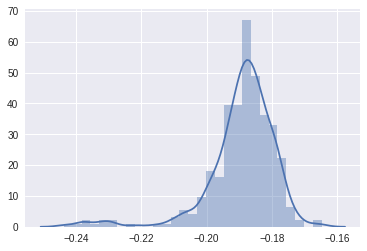

In [37]:
distplot(HOMO)

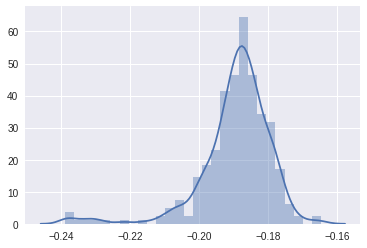

In [36]:
distplot(HOMOTrain)

In [22]:
runGrid('extraTrees',maccs)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.75211047587


In [24]:
runGrid('extraTrees',maccsTrain, HOMOTrain,0.6)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.613144772035


In [27]:
runGrid('extraTrees',atom)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.741860482387


In [28]:
runGrid('extraTrees',atomTrain, HOMOTrain,0.5)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.545062316119
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.556998768442


In [28]:
runGrid('extraTrees',topo,HOMO,0.65)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.668618481362


In [29]:
runGrid('extraTrees',topoTrain, HOMOTrain,0.5)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.579223129964


In [26]:
runGrid('extraTrees',morgan)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.734379461321


In [30]:
runGrid('extraTrees',morganTrain, HOMOTrain,0.5)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.606062900449


### Combined Fingerprints 

In [17]:
HOMO = loadNumpy('HOMO')


maccs = loadNumpy('maccsCount')
ap = loadNumpy('AtomPairCount')
maccsAtom = hstack((maccs,atom))

In [ ]:
maccsInvariant = generateInVariantMACCS(maccs)

In [48]:
saveNumpy(maccsInvariant,'maccsInvariant')

maccsInvariant saved successfully in .


In [ ]:
maccsAtomUniq = hstack((maccsInvariant,atom))

In [51]:
saveNumpy(maccsAtomUniq,'maccsAtomUniq')

maccsAtomUniq saved successfully in .


### Generate a MACCS fingerprint removing any features that are invariant across the dataset

In [44]:
def generateInVariantMACCS(MACCS):
    nonZeroList = []
    for fp in MACCS:
        nonZero = nonzero(fp)[0]
        nonZeroList += nonZero.tolist()
    
    inVariantIndices = list(set(nonZeroList))
    
    maccsInvariant = []
    for fp in MACCS:
        reducedMolecule = []
        for i in inVariantIndices:
            reducedMolecule += [fp[i]]
            
        maccsInvariant += [array(reducedMolecule)]
    
    return array(maccsInvariant)
        

In [21]:
from numpy import nonzero

In [45]:
maccsInvariant = generateInVariantMACCS(maccs)

In [49]:
maccsAtomUniq = hstack((maccsInvariant,atom))

In [50]:
runGrid('extraTrees',maccsAtomUniq)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.710252101831
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.713999866268


In [52]:
runGrid('randomForest',maccsAtomUniq)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.25, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.708463229639


KeyboardInterrupt: 

In [18]:
runGrid('extraTrees',maccsAtom)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.711763933073
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.720554117096
